In [6]:
import warnings
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame, Series
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

# suppress warnings outcoming from sklearn models


def warn(*args, **kwargs):
    pass


warnings.warn = warn


class RandomForestMSE:
    def __init__(
        self, n_estimators, *, max_depth=None, feature_subsample_size=None,
        splitter='best', bootstrap=None, random_state=42, **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.

        splitter: ['best', 'random']
            Criterion for splitting nodes in in trees

        bootstrap: None | int | float
            if None bootstraping is not performed. Otherwise defines splits for bootstraping

        random_state : int
            set the random state for estimators. 42 by default
        """
        self.trees = None

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.splitter = splitter
        self.random_state = random_state
        self.bootstrap = bootstrap

        # check if feature_subsample_size is in valid range of values
        if isinstance(feature_subsample_size, float) and \
                (feature_subsample_size > 1.0 or feature_subsample_size < 0.0):
            raise ValueError(
                'feature_subsample_size must be in range [0,1] or be integer')
        self.fss = feature_subsample_size if feature_subsample_size is not None else 1/3

        self.tree_parameters = trees_parameters

    def fit(self, X: np.ndarray, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects
        """
        self.trees = []

        # if X or y are not numpy datastructures than redefine them
        if isinstance(X, DataFrame):
            X = X.to_numpy()
        if isinstance(y, Series):
            y = y.to_numpy()

        # generator, used in trees random_state
        rnd_gen = np.random.Generator(np.random.PCG64(self.random_state))

        # check if predefined fss is less than count of features in objects
        if (isinstance(self.fss, int) and self.fss > X.shape[1]):
            raise ValueError(
                'X have less features than expected by feature_subsample_size')

        # if bootstrapping is enabled check and prepare splitting point
        bootstrap = None
        if self.bootstrap is not None:
            if (isinstance(self.bootstrap, int) and self.bootstrap > X.shape[0] or
                    isinstance(self.bootstrap, float) and (self.bootstrap > 1.0 or self.bootstrap < 0)):
                raise ValueError('bootstrap index out of range')
            else:
                bootstrap = self.bootstrap if isinstance(
                    self.bootstrap, int) else round(self.bootstrap * X.shape[0])

        history = None
        if X_val is not None and y_val is not None:
            history = {
                'mse': [],
                'r2': [],
                'mape': [],
                'mae': []
            }

        for _ in range(self.n_estimators):
            idx = np.random.permutation(
                X.shape[0])[:bootstrap] if bootstrap is not None else np.arange(X.shape[0])

            # define tree structure
            tree = DecisionTreeRegressor(
                criterion='squared_error',
                splitter=self.splitter,
                max_depth=self.max_depth,
                max_features=self.fss,
                random_state=rnd_gen.integers(0, 100_000_000),
                **self.tree_parameters
            )
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)

            if history is not None:
                mse, mae, r2, mape = self.make_metrics(X_val, y_val)
                history['mse'].append(mse)
                history['mae'].append(mae)
                history['r2'].append(r2)
                history['mape'].append(mape)

        return self if history is None else history

    def make_metrics(self, X, y):
        preds = self.predict(X)

        mse = mean_squared_error(y, preds)
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)
        mape = mean_absolute_percentage_error(y, preds)

        return mse, mae, r2, mape

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        # if model is not fitted yet raise error
        if self.trees is None:
            raise ValueError('model is not fited')
        preds = np.array([tree.predict(X) for tree in self.trees])

        return np.mean(preds, axis=0)


class GradientBoostingMSE:
    def __init__(
        self, n_estimators, *, learning_rate=0.1, max_depth=5,
        splitter='best', feature_subsample_size=None, random_state=42,
        bootstrap=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use alpha * learning_rate instead of alpha

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float | None
            The size of feature set for each tree. If None then use one-third of all features.


        splitter: ['best', 'random']
            Criterion for splitting nodes in in trees


        splitter: ['best', 'random']
            Criterion for splitting nodes in in trees

        bootstrap: None | int | float
            if None bootstraping is not performed. Otherwise defines splits for bootstraping

        random_state : int
            set the random state for estimators. 42 by default
        """
        self.weights = None
        self.trees = None

        self.n_estimators = n_estimators
        self.lr = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.splitter = splitter
        self.bootstrap = bootstrap

        # check if feature_subsample_size is in valid range of values
        if isinstance(feature_subsample_size, float) and \
                (feature_subsample_size > 1.0 or feature_subsample_size < 0.0):
            raise ValueError(
                'feature_subsample_size must be in range [0,1] or be integer')
        self.fss = feature_subsample_size if feature_subsample_size is not None else 1/3
        self.trees_parameters = trees_parameters

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects
        """
        self.weights = []
        self.trees = []

        # if X or y are not numpy datastructures than redefine them
        if isinstance(X, DataFrame):
            X = X.to_numpy()
        if isinstance(y, Series):
            y = y.to_numpy()

        # generator, used in trees random_state
        rnd_gen = np.random.Generator(np.random.PCG64(self.random_state))

        # check if predefined fss is less than count of features in objects
        if (isinstance(self.fss, int) and self.fss > X.shape[1]):
            raise ValueError(
                'X have less features than expected by feature_subsample_size')

        # if bootstrapping is enabled check and prepare splitting point
        bootstrap = None
        if self.bootstrap is not None:
            if (isinstance(self.bootstrap, int) and self.bootstrap > X.shape[0] or
                    isinstance(self.bootstrap, float) and (self.bootstrap > 1.0 or self.bootstrap < 0)):
                raise ValueError('bootstrap index out of range')
            else:
                bootstrap = self.bootstrap if isinstance(
                    self.bootstrap, int) else round(self.bootstrap * X.shape[0])

        history = None
        if X_val is not None and y_val is not None:
            history = {
                'mse': [],
                'r2': [],
                'mape': [],
                'mae': []
            }

        # initialize first target for boosting
        grad = y
        for _ in range(self.n_estimators):
            idx = np.random.permutation(
                X.shape[0])[:bootstrap] if bootstrap is not None else np.arange(X.shape[0])

            tree = DecisionTreeRegressor(
                criterion='squared_error',
                splitter=self.splitter,
                max_features=self.fss,
                random_state=rnd_gen.integers(0, 100_000_000),
                max_depth=self.max_depth,
                **self.trees_parameters
            )
            tree = tree.fit(X[idx], grad[idx])
            preds = tree.predict(X)
            alpha = minimize_scalar(fun=lambda a: np.sum(
                (grad - a * preds) ** 2), bounds=(0, 10000)).x

            grad -= self.lr * alpha * preds
            self.trees.append(tree)
            self.weights.append(self.lr * alpha)

            if history is not None:
                mse, mae, r2, mape = self.make_metrics(X_val, y_val)
                history['mse'].append(mse)
                history['mae'].append(mae)
                history['r2'].append(r2)
                history['mape'].append(mape)

        return self if history is None else history

    def make_metrics(self, X, y):
        preds = self.predict(X)

        mse = mean_squared_error(y, preds)
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)
        mape = mean_absolute_percentage_error(y, preds)

        return mse, mae, r2, mape

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        # if model is not fitted yet raise error
        if self.trees is None or self.weights is None:
            raise ValueError('model is not fited')
        preds = np.array([w * tree.predict(X)
                         for w, tree in zip(self.weights, self.trees)])
        return np.sum(preds, axis=0)

In [1]:
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('./kc_house_data.csv')

In [4]:
data.drop(columns=['id', 'date']).to_csv('./data_clear.csv', index=False)

In [12]:
ind = np.random.permutation(data.drop(columns=['id', 'date']).shape[0])
data.drop(columns=['id', 'date']).loc[ind[:int(len(ind) * 0.3)]
                                      ].to_csv('./data_clear_test.csv', index=False)
data.drop(columns=['id', 'date']).loc[ind[int(len(ind) * 0.3):]
                                      ].to_csv('./data_clear_train.csv', index=False)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['id', 'date']), data.price, test_size=0.3)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor(
    n_estimators=1000, max_depth=None, max_features=1/3, bootstrap=False)
m.fit(X_train, y_train)
mean_squared_error(m.predict(X_test), y_test)

In [9]:
from sklearn.metrics import mean_squared_error
coll = GradientBoostingMSE(n_estimators=10, max_depth=None,
                           learning_rate=0.01, feature_subsample_size=None)
print(coll.fit(X_train, y_train, X_test, y_test))
# prds = coll.predict(X_test)
# mean_squared_error(prds, y_test)

None


In [ ]:
answ.shape

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

""


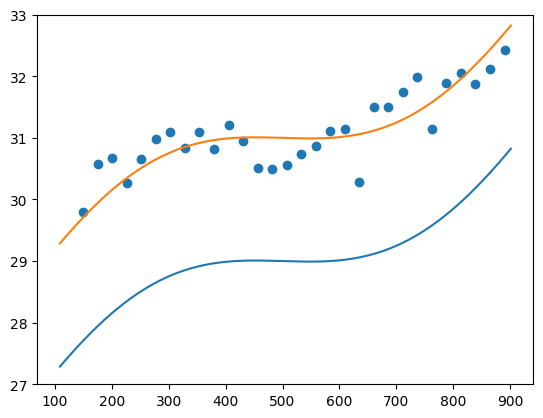

In [43]:
lsp = np.linspace(10, 1000, 10_000)[1000: 9000]
plt.ylim((27, 33))
plt.plot(lsp, np.sin((lsp / 500) * np.pi) + 26 + 6 * lsp / 1000)
plt.plot(lsp, np.sin((lsp / 500) * np.pi) + 28 + 6 * lsp / 1000)
scatlnsp = np.linspace(150, 890, 30)
plt.scatter(scatlnsp, (np.sin((scatlnsp / 500) * np.pi) + 28 + 6 *
            scatlnsp / 1000) + np.random.normal(0, 0.4, size=len(scatlnsp)))

In [51]:
# , 'f_b': np.sin((lsp / 500) * np.pi) + 28 + 6 * lsp / 1000})
data_plot = pd.DataFrame({'x': lsp, 'f': np.sin(
    (lsp / 500) * np.pi) + 26 + 6 * lsp / 1000})

In [52]:
data_plot.to_csv('./function_bias_plot.csv', header=None, index=False)